In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.1


In [4]:
data_path = "../Data/KU-HAR/deploy"
train_X = np.load(data_path+'/train_x.npy')
train_Y = np.load(data_path+'/train_y.npy')
test_X = np.load(data_path+'/test_x.npy')
test_Y = np.load(data_path+'/test_y.npy')

train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_Y))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [5]:
print(train_X.shape)
print(train_Y.shape)

(16524, 300, 6)
(16524, 18)


In [16]:
input_nc = 6
segment_size = 300
class_num = 18

class Model(tf.keras.Model):

  def __init__(self):
    super(Model, self).__init__()
    self.backbone = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, 3, strides=1, padding='SAME', activation='relu', input_shape=(segment_size, input_nc)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(128, 3, strides=1, padding='SAME', activation='relu'),
        tf.keras.layers.Conv1D(128, 3, strides=1, padding='SAME', activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last'),
    ])

    self.fc = tf.keras.layers.Dense(class_num, name='dense_1')

  def call(self, x, training=True):
    features = self.backbone(x)
    return self.fc(features)


In [17]:
NUM_EPOCHS = 300
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
train_ds = train_ds.batch(BATCH_SIZE)

m.compile(
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy']
)

def decay(epoch):
    if epoch < 150:
      return 0.1
    if epoch >= 150 and epoch < 225:
      return 0.01
    if epoch >= 225:
      return 0.001

m.fit(train_dataset, epochs=300, validation_data=test_dataset,
        verbose=2, callbacks=[tf.keras.callbacks.LearningRateScheduler(
            decay)])


Epoch 1/300
259/259 - 6s - loss: 8.8532 - accuracy: 0.0228 - val_loss: 9.0754 - val_accuracy: 0.0208 - lr: 0.1000 - 6s/epoch - 22ms/step
Epoch 2/300
259/259 - 1s - loss: 9.0306 - accuracy: 0.0225 - val_loss: 9.0754 - val_accuracy: 0.0208 - lr: 0.1000 - 767ms/epoch - 3ms/step
Epoch 3/300
259/259 - 1s - loss: 9.0306 - accuracy: 0.0225 - val_loss: 9.0754 - val_accuracy: 0.0208 - lr: 0.1000 - 763ms/epoch - 3ms/step
Epoch 4/300
259/259 - 1s - loss: 9.0306 - accuracy: 0.0225 - val_loss: 9.0754 - val_accuracy: 0.0208 - lr: 0.1000 - 763ms/epoch - 3ms/step
Epoch 5/300
259/259 - 1s - loss: 9.0306 - accuracy: 0.0225 - val_loss: 9.0754 - val_accuracy: 0.0208 - lr: 0.1000 - 774ms/epoch - 3ms/step
Epoch 6/300
259/259 - 1s - loss: 9.0306 - accuracy: 0.0225 - val_loss: 9.0754 - val_accuracy: 0.0208 - lr: 0.1000 - 765ms/epoch - 3ms/step
Epoch 7/300
259/259 - 1s - loss: 9.0306 - accuracy: 0.0225 - val_loss: 9.0754 - val_accuracy: 0.0208 - lr: 0.1000 - 776ms/epoch - 3ms/step
Epoch 8/300
259/259 - 1s - lo

KeyboardInterrupt: 

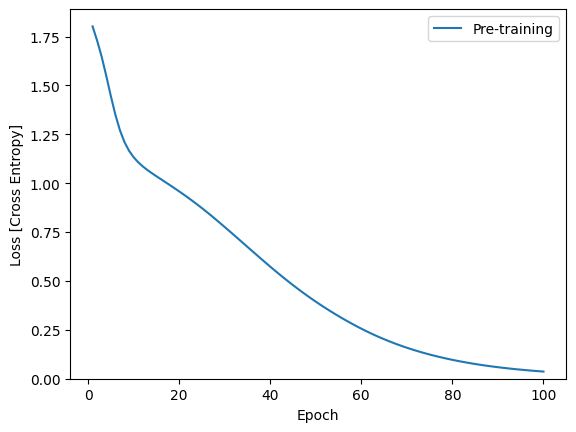

In [6]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

In [7]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [10]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

logits_original = m.infer(x=train_X[:1])['logits'][0]
logits_lite = infer(x=train_X[:1])['logits'][0]

In [ ]:
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)